### Fazendo Download das Imagens
##### O código abaixo irá baixar imagens automaticamente:
    - 100 imagens de pessoas com óculos
    - 100 imagens de pessoas
###### Este código é equivalente a digitar "person" e "person with glasses" no buscador e então baixar as 100 primeiras imagens de cada busca

In [1]:
from bing_image_downloader.downloader import download


query_string = 'person'
#download(query_string, limit=100,  output_dir='downloads', adult_filter_off=True, force_replace=False, timeout=60, verbose=True)

query_string = 'person with glasses'
#download(query_string, limit=100,  output_dir='downloads', adult_filter_off=True, force_replace=False, timeout=60, verbose=True)

#### Excluindo Imagens Corrompidas
##### O código abaixo irá percorrer os diretórios dentro do diretório "downloads" e excluir qualquer imagem que esteja corrompida

In [2]:
import cv2
import os

def exclude_files(path_to_exclude):
    paths_to_exclude= os.listdir(path_to_exclude)
    for path in paths_to_exclude:
        if path != 'models':
            for file in os.listdir(os.path.join(path_to_exclude,path)):      
                img = cv2.imread(os.path.join(path_to_exclude,path,file))
                if img is None:
                    print("\t Exclude file: {}".format(file))
                    os.system("del {}".format((os.path.join(path_to_exclude,path,file))))

exclude_files('downloads')

#### Tudo pronto com nosso dataset!
##### O código abaixo irá carregar as imagens que foram baixadas
##### Iremos também avaliar com quantas imagens iremos treinar nosso modelo, e quantas iremos usar para validar nosso modelo.

As imagens serão classficiadas entre person e person with glasses
Quantidade de imagens para treinamento: 141
Quantidade de imagens para validação: 35


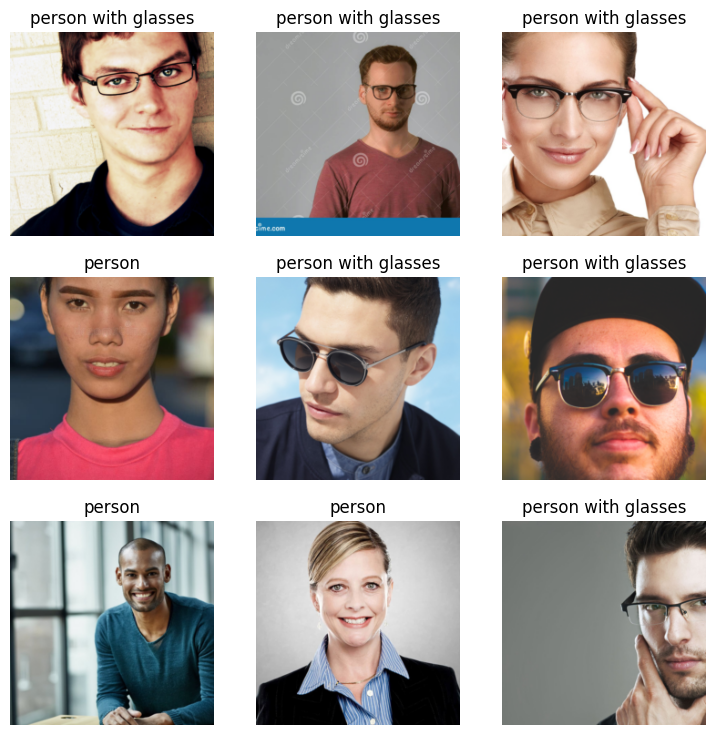

In [3]:
from fastai.vision.all import *
import numpy as np
import warnings
warnings.filterwarnings("ignore")


np.random.seed(53)
dls = ImageDataLoaders.from_folder('downloads', train='.', valid_pct=0.2, seed=42, item_tfms=Resize(224))

dls.show_batch()

print(f"As imagens serão classficiadas entre {' e '.join(dls.vocab)}")
print(f"Quantidade de imagens para treinamento: {len(dls.train_ds)}")
print(f"Quantidade de imagens para validação: {len(dls.valid_ds)}")


# Instanciando e Treinando o Modelo

#### No código abaixo estamos passando nosso "dataset" e escolhendo o modelo "resnet34" para instanciar o que chamamos de "learner"

In [4]:
from fastai.learner import Learner
learn: Learner = vision_learner(dls, models.resnet34, pretrained=True, metrics=[accuracy, Recall(), Precision(), F1Score()])



epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,f1_score,time
0,1.024394,2.094386,0.428571,0.000000,0.000000,0.000000,00:15
1,1.069266,1.228289,0.457143,0.105263,0.500000,0.173913,00:15
2,0.954118,0.599570,0.714286,0.631579,0.800000,0.705882,00:16
3,0.800544,0.433649,0.771429,0.789474,0.789474,0.789474,00:16
4,0.687285,0.400029,0.800000,0.842105,0.800000,0.820513,00:16
5,0.606675,0.390461,0.828571,0.842105,0.842105,0.842105,00:15
6,0.535516,0.392728,0.857143,0.842105,0.888889,0.864865,00:15
7,0.476199,0.388202,0.857143,0.842105,0.888889,0.864865,00:15
8,0.432269,0.386510,0.857143,0.842105,0.888889,0.864865,00:15
9,0.396060,0.377853,0.857143,0.842105,0.888889,0.864865,00:16


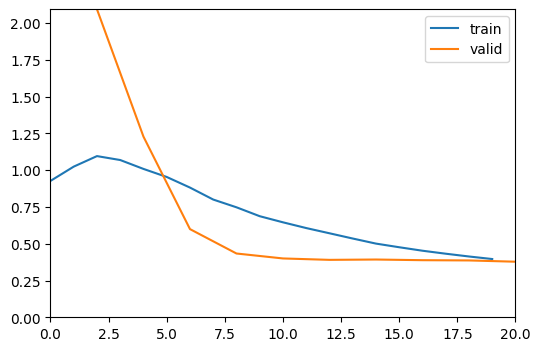

Path('downloads/models/stage1.pth')

In [5]:
#learn.fit_one_cycle(10, cbs=[ShowGraphCallback()])
#learn.save('stage1')

### Carregando o modelo salvo

In [6]:
learn.load('stage1')

# Métricas de Validação

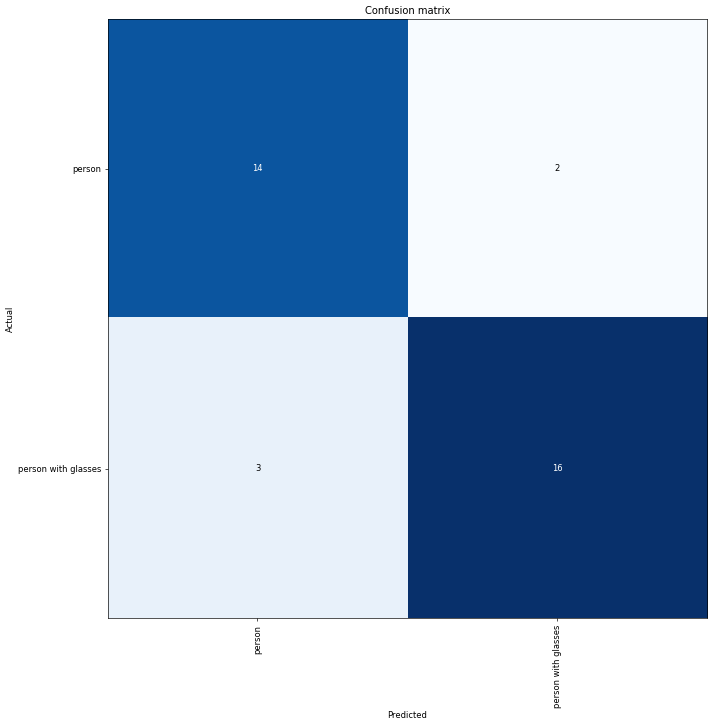

In [7]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)


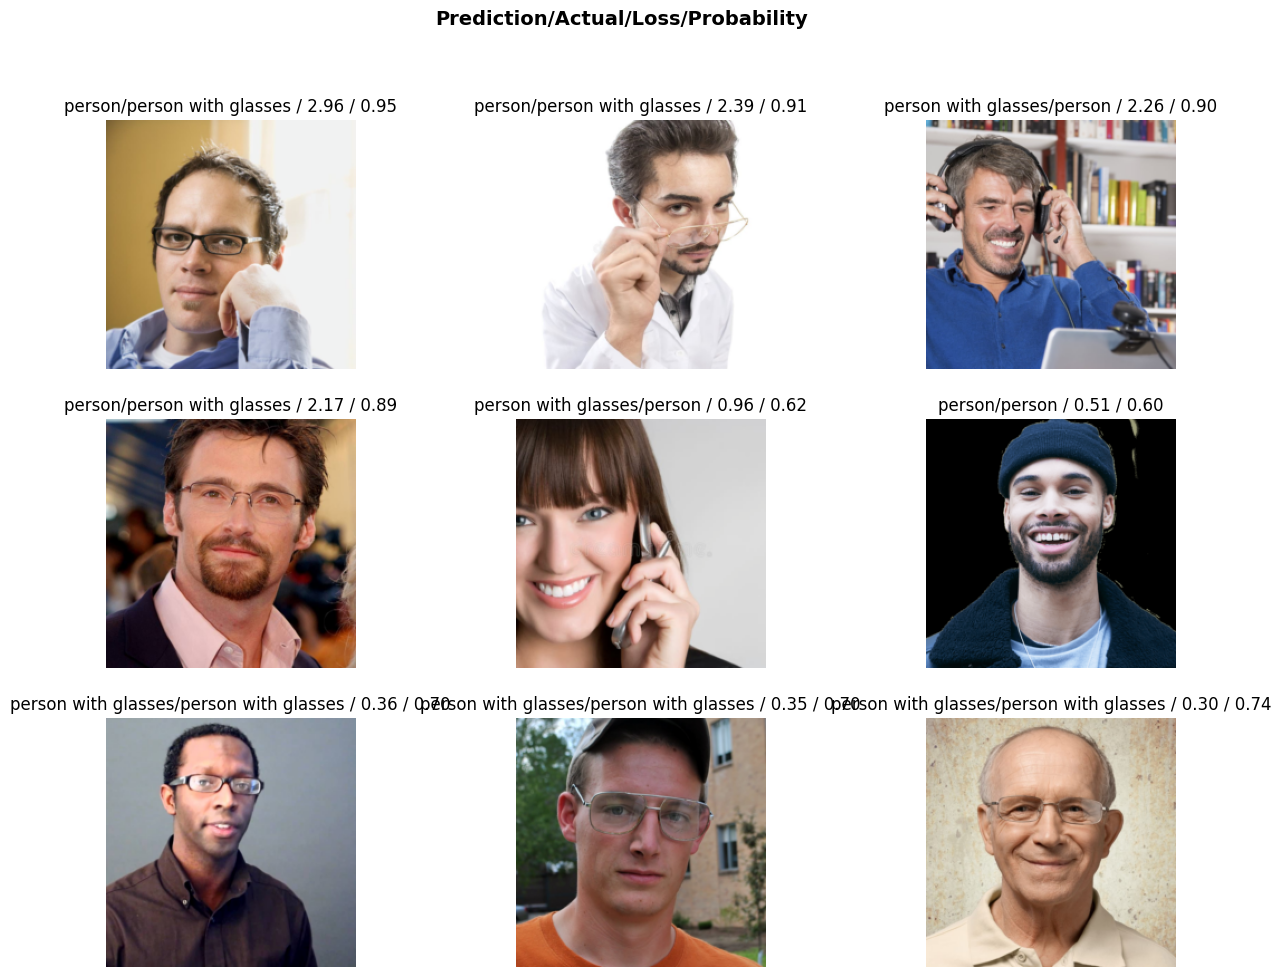

In [8]:
interp.plot_top_losses(9, figsize=(15,11)) #,heatmat=True

# Realizando predições com o modelo treinado

In [9]:
from torchvision import transforms
from PIL import Image

CLASSE DE TESTE: person with glasses
IMAGE DE TESTE : Image_61.jpg


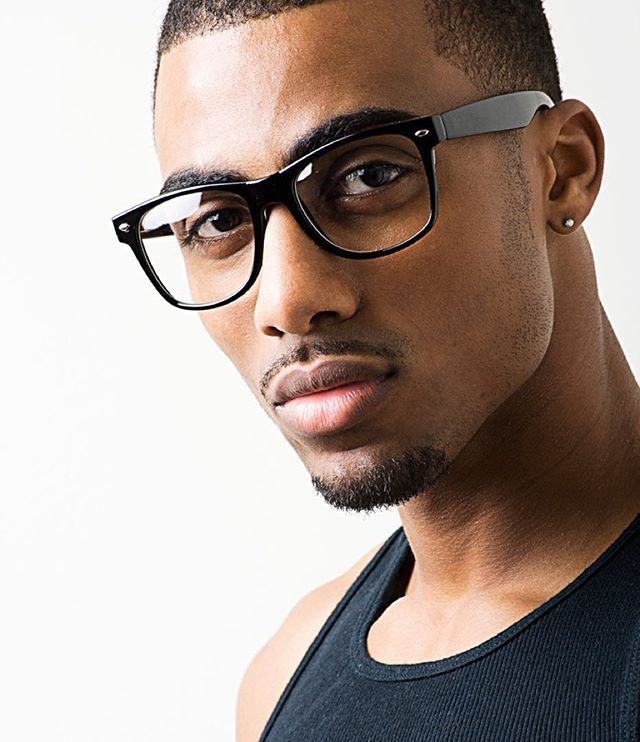

In [16]:
## Open Image

#test_class = random.choice(dls.vocab)
test_class = "person with glasses"
print(f"CLASSE DE TESTE: {test_class}")

#test_image = random.choice(os.listdir(os.path.join('downloads',test_class)))
test_image = "Image_61.jpg"
print(f"IMAGE DE TESTE : {test_image}")


image_path = os.path.join('downloads',test_class,test_image)
image = Image.open(image_path).convert('RGB')
image


Probabilities: 
	person: 0.00 %
	person with glasses: 100.00 %

Prediction: PERSON WITH GLASSES


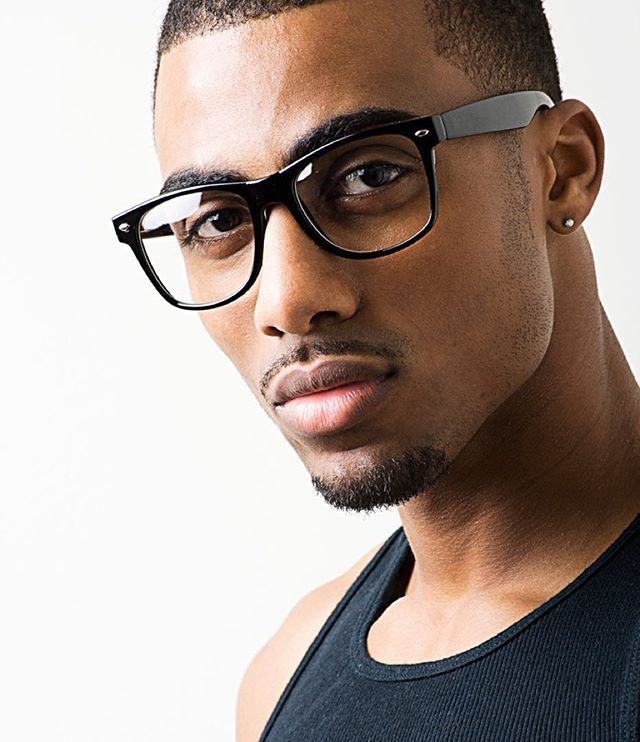

In [11]:
# predict image with learn
pred,pred_idx,probs = learn.predict(image)
print("Probabilities: ")
for i in range(len(dls.vocab)):
    print(f"\t{dls.vocab[i]}: {probs[i].item()*100:.02f} %")

print(f"\nPrediction: {pred.upper()}")
image


# GRAD-CAM

In [12]:
class Hook():
    def __init__(self, m):
        self.hook = m.register_forward_hook(self.hook_func)   
    def hook_func(self, m, i, o): self.stored = o.detach().clone()
    def __enter__(self, *args): return self
    def __exit__(self, *args): self.hook.remove()
class HookBwd():
    def __init__(self, m):
        self.hook = m.register_backward_hook(self.hook_func)   
    def hook_func(self, m, gi, go): self.stored = go[0].detach().clone()
    def __enter__(self, *args): return self
    def __exit__(self, *args): self.hook.remove()

In [13]:
x = first(dls.test_dl([image]))[0]
cls = list(dls.vocab).index(test_class)
with HookBwd(learn.model[0]) as hookg:
    with Hook(learn.model[0]) as hook:
        output = learn.model.eval()(x)
        act = hook.stored
    output[0,cls].backward()
    grad = hookg.stored

In [14]:
w = grad[0].mean(dim=[1,2], keepdim=True)
cam_map = (w * act[0]).sum(0)
cam_map.shape

torch.Size([7, 7])

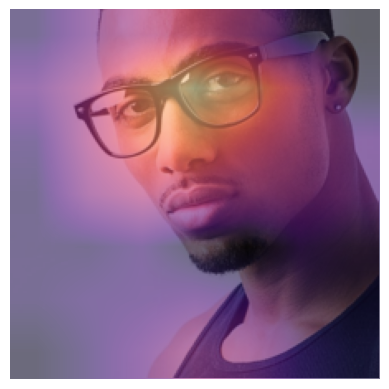

In [15]:
x_dec = TensorImage(dls.train.decode((x,))[0][0])
_,ax = plt.subplots()
x_dec.show(ctx=ax)
ax.imshow(cam_map.detach().cpu(), alpha=0.6, extent=(0,224,224,0),
              interpolation='bilinear', cmap='magma');